In [12]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
import networkx as nx
from sklearn.metrics import mean_squared_error

In [13]:
class DiffusionGraphKernel(gpytorch.kernels.Kernel):
    def __init__(self, laplacian_matrix, **kwargs):
        super().__init__(**kwargs)
        
        # Store graph Laplacian
        self.register_buffer('L', torch.tensor(laplacian_matrix.toarray(), dtype=torch.float32))
        
        # Initialize lengthscale parameter
        self.register_parameter(name="raw_lengthscale", parameter=torch.nn.Parameter(torch.zeros(1)))
        
    @property
    def lengthscale(self):
        return torch.exp(self.raw_lengthscale)
        
    def forward(self, x1, x2, diag=False, **params):
        # Compute diffusion kernel: K = exp(-t * L)
        t = self.lengthscale
        
        # Matrix exponential of -t*L
        eigenvals, eigenvecs = torch.linalg.eigh(self.L)
        exp_eig = torch.exp(-t * eigenvals)
        K = eigenvecs @ torch.diag(exp_eig) @ eigenvecs.T
        
        if diag:
            return torch.diag(K)
        
        # Extract submatrix based on indices
        x1_idx = x1.long().squeeze()
        x2_idx = x2.long().squeeze()
        
        return K[x1_idx[:, None], x2_idx[None, :]]

In [14]:
# Generate ring graph
np.random.seed(42)
torch.manual_seed(42)

n_nodes = 50

# Create ring graph (cycle graph)
G = nx.cycle_graph(n_nodes)
A = nx.adjacency_matrix(G)
L = laplacian(A, normed=True)

# Generate function that respects ring topology
# Use angular position on the ring for a smooth function
angles = np.linspace(0, 2*np.pi, n_nodes, endpoint=False)
true_func = lambda theta: 2*np.sin(2*theta) + 0.5*np.cos(4*theta) + 0.3*np.sin(theta)
y_true = true_func(angles)

# Add noise
noise_std = 0.1
y_observed = y_true + np.random.normal(0, noise_std, n_nodes)

# Training/test split
train_idx = np.random.choice(n_nodes, size=int(0.7 * n_nodes), replace=False)
test_idx = np.setdiff1d(np.arange(n_nodes), train_idx)

X_train = torch.tensor(train_idx, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_observed[train_idx], dtype=torch.float32)
X_test = torch.tensor(test_idx, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_observed[test_idx], dtype=torch.float32)

print(f"Ring graph: {n_nodes} nodes, {G.number_of_edges()} edges")
print(f"Training set: {len(train_idx)} nodes")
print(f"Test set: {len(test_idx)} nodes")

Ring graph: 50 nodes, 50 edges
Training set: 35 nodes
Test set: 15 nodes


In [15]:
class GraphGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, laplacian_matrix):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Use ScaleKernel to add output scaling to our custom kernel
        base_kernel = DiffusionGraphKernel(laplacian_matrix)
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GraphGPModel(X_train, y_train, likelihood, L)

In [16]:
# Training
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    
    if i % 20 == 0:
        print(f'Iter {i+1}/{training_iter} - Loss: {loss.item():.3f} - '
              f'Lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f} - '
              f'Output scale: {model.covar_module.outputscale.item():.3f} - '
              f'Noise: {likelihood.noise.item():.3f}')
    
    optimizer.step()

Iter 1/100 - Loss: 1.767 - Lengthscale: 1.000 - Output scale: 0.693 - Noise: 0.693
Iter 21/100 - Loss: 1.440 - Lengthscale: 5.707 - Output scale: 2.030 - Noise: 0.599
Iter 41/100 - Loss: 0.711 - Lengthscale: 10.944 - Output scale: 3.890 - Noise: 0.068
Iter 61/100 - Loss: 0.288 - Lengthscale: 14.936 - Output scale: 5.571 - Noise: 0.008
Iter 81/100 - Loss: 0.222 - Lengthscale: 16.491 - Output scale: 6.794 - Noise: 0.011


In [17]:
# Prediction
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Predict on test nodes
    test_pred = likelihood(model(X_test))
    test_mean = test_pred.mean
    test_std = test_pred.stddev
    
    # Predict on all nodes for visualization
    X_all = torch.arange(n_nodes, dtype=torch.float32).unsqueeze(1)
    all_pred = likelihood(model(X_all))
    all_mean = all_pred.mean
    all_std = all_pred.stddev

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test.numpy(), test_mean.numpy()))
print(f"\nTest RMSE: {test_rmse:.4f}")
print(f"Test noise std: {noise_std:.4f}")


Test RMSE: 0.1165
Test noise std: 0.1000


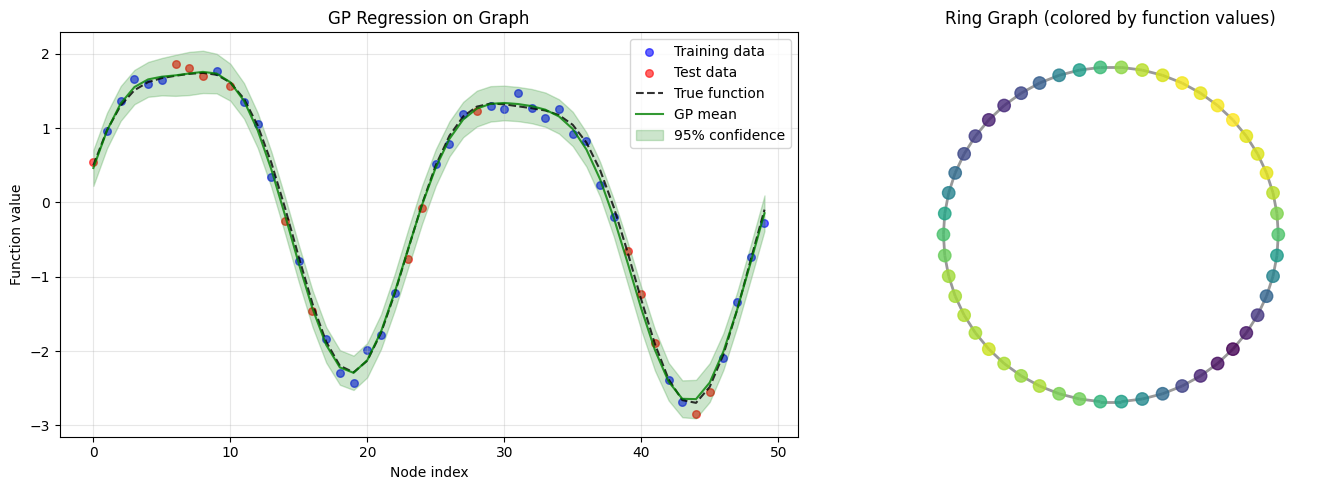


Learned parameters:
Lengthscale: 17.4313
Output scale: 7.7273
Noise variance: 0.0103


In [18]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: GP predictions vs true function
ax1.scatter(train_idx, y_train.numpy(), color='blue', alpha=0.6, label='Training data', s=30)
ax1.scatter(test_idx, y_test.numpy(), color='red', alpha=0.6, label='Test data', s=30)
ax1.plot(range(n_nodes), y_true, 'k--', label='True function', alpha=0.8)
ax1.plot(range(n_nodes), all_mean.numpy(), 'g-', label='GP mean', alpha=0.8)
ax1.fill_between(range(n_nodes), 
                 all_mean.numpy() - 2*all_std.numpy(),
                 all_mean.numpy() + 2*all_std.numpy(),
                 alpha=0.2, color='green', label='95% confidence')
ax1.set_xlabel('Node index')
ax1.set_ylabel('Function value')
ax1.set_title('GP Regression on Graph')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Graph structure (ring layout)
pos = {}
for i in range(n_nodes):
    angle = 2 * np.pi * i / n_nodes
    pos[i] = (np.cos(angle), np.sin(angle))

nx.draw(G, pos, ax=ax2, node_color=y_observed, node_size=80, 
        cmap='viridis', with_labels=False, edge_color='gray', alpha=0.8, width=2)
ax2.set_title('Ring Graph (colored by function values)')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"\nLearned parameters:")
print(f"Lengthscale: {model.covar_module.base_kernel.lengthscale.item():.4f}")
print(f"Output scale: {model.covar_module.outputscale.item():.4f}")
print(f"Noise variance: {likelihood.noise.item():.4f}")